In [1]:
import itertools
import numpy as np
import time
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange, tqdm
import tensorflow_privacy
from typing import Tuple

print("gpu available:", tf.test.is_gpu_available())
rng = np.random.RandomState(123)
tf.random.set_seed(42)
plt.rcParams['font.size'] = 18

dtype = np.float64
gpflow.config.set_default_float(dtype)

2022-07-27 16:56:36.056577: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-27 16:56:36.059642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 16:56:36.059654: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
gpu available: False


2022-07-27 16:56:37.831976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 16:56:37.880477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 16:56:37.880535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-27 16:56:37.880572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot ope

## Let's generate some synthetic training data ...

In [2]:
save_figs=True
N = 10_000  # Number of training observations
def func(x):
    return np.sin(x * 6) + 0.3 * np.cos(x * 3) + 0.5 * np.sin(x * 15)

X = rng.rand(N, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * rng.randn(N, 1)  # Noisy Y values
X = X.astype(dtype)
Y = Y.astype(dtype)
data = (X, Y)
X.dtype, Y.dtype

(dtype('float64'), dtype('float64'))

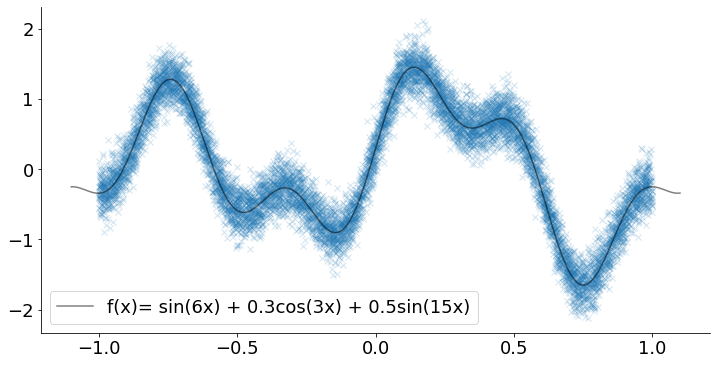

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "x", alpha=0.2)
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
_ = plt.plot(Xt, Yt, c="k", alpha=0.5, label='f(x)= sin(6x) + 0.3cos(3x) + 0.5sin(15x)')
sns.despine()
plt.legend()
plt.savefig("figures/dp_vfe/underlying_func.pdf") if save_figs else 0

In [4]:
from dp_gp.approximate_inference.common_train_logic import make_SVGP_model, simple_training_loop
Z = np.random.uniform(-1, 1, size=(50, 1))
m = make_SVGP_model(num_inducing=50, num_data=len(X), Z_init=Z, num_features=1)
m

2022-07-27 16:56:38.721781: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


name,class,transform,prior,trainable,shape,dtype,value
SVGP_psg.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGP_psg.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP_psg.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP_psg.inducing_variable.Z,Parameter,Identity,,True,"(50, 1)",float64,[[-0.98207597...
SVGP_psg.q_mu,Parameter,Identity,,True,"(50, 1)",float64,[[0....
SVGP_psg.q_sqrt,Parameter,FillTriangular,,True,"(1, 50, 50)",float64,"[[[1., 0., 0...."


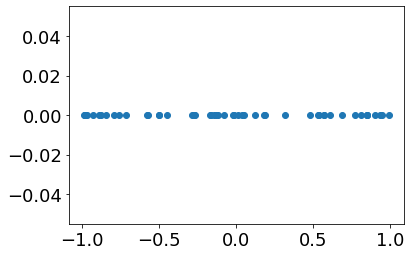

In [15]:
plt.scatter(Z, np.zeros_like(Z))

In [5]:
elbo = tf.function(m.elbo)

In [6]:
# check elbo returns a vector not a scalar
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)
train_iter = iter(train_dataset.batch(100))
elbo(next(train_iter)).shape

TensorShape([100])

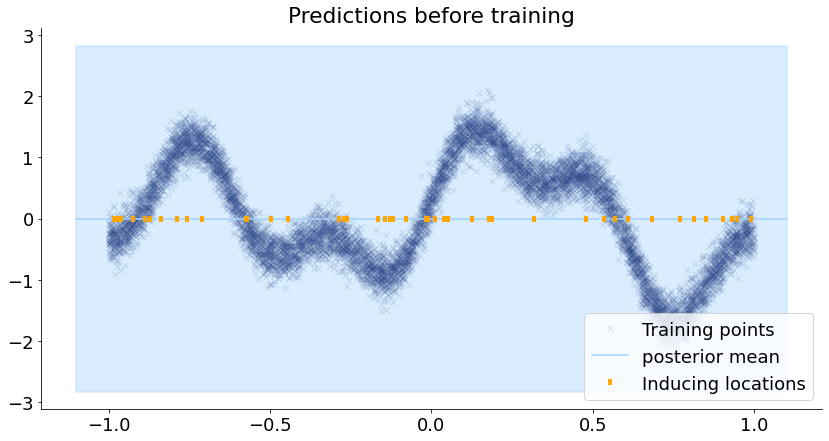

In [7]:
def plot(title=""):
    plt.figure(figsize=(14, 7))
    plt.title(title)
    pX = np.linspace(-1.1, 1.1, 100, dtype=dtype)[:, None]  # Test locations
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X, Y, "x", label="Training points", alpha=0.15, color='#264185')
    (line,) = plt.plot(pX, pY, lw=1.5, label="posterior mean", color='#A2D2FF', alpha=1.0)
    plt.fill_between(
        pX[:, 0],
        (pY - 2 * pYv ** 0.5)[:, 0],
        (pY + 2 * pYv ** 0.5)[:, 0],
        color='#A2D2FF',
        alpha=0.4,
        lw=1.5,
    )
    Z = m.inducing_variable.Z.numpy()
    plt.plot(Z, np.zeros_like(Z), "k|", mew=4, label="Inducing locations", color='orange')
    plt.legend(loc="lower right")
    sns.despine()

plot(title="Predictions before training")

In [8]:
from dp_gp.dp_tools.dp_gd_optimizer import VectorizedDPKerasAdamOptimizer

BATCH_SIZE = 128
EPOCHS = 70
L2_CLIP = 15.0
NOISE_MULT = 5.0
LR = 1e-2
delta = round(1/len(X), 5)

DP=True

if DP:
        print("using private optimizer")
        opt = VectorizedDPKerasAdamOptimizer(
                l2_norm_clip=L2_CLIP,
                noise_multiplier=NOISE_MULT,
                num_microbatches=BATCH_SIZE,
                learning_rate=LR,
        )
else:
        print("using non private optimizer")
        opt = tf.keras.optimizers.Adam(learning_rate=LR)

using private optimizer


In [9]:
train_losses, train_elbos = simple_training_loop(
            model=m,
            data=(X, Y),
            optimizer=opt,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            logging_batch_freq=25)

loss: 171.449 ELBO: -97.860: 100%|██████████| 5460/5460 [02:24<00:00, 37.82it/s]


### Computing differential privacy guarantee


In [10]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
eps, _ = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=len(X),
                                              batch_size=BATCH_SIZE,
                                              noise_multiplier=NOISE_MULT,
                                              epochs=EPOCHS,
                                              delta=delta)
eps = np.inf if not DP else eps

DP-SGD with sampling rate = 1.28% and noise_multiplier = 5.0 iterated over 5469 steps satisfies differential privacy with eps = 0.645 and delta = 0.0001.
The optimal RDP order is 19.0.


## Plot predictions

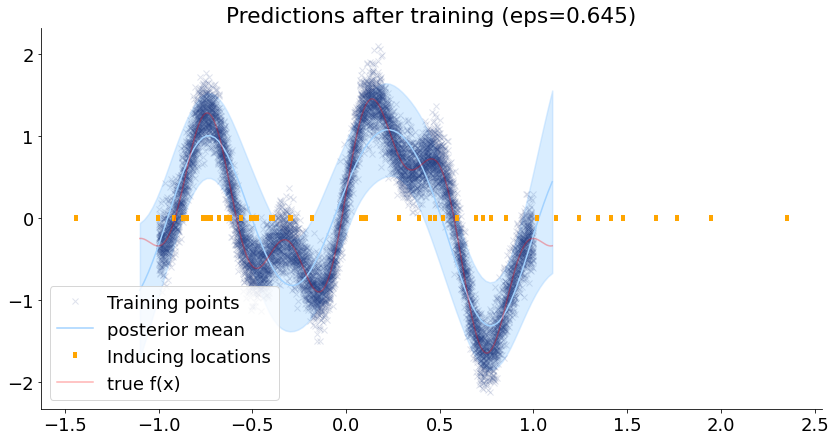

In [11]:
plot(f"Predictions after training (eps={eps:.3f})")
plt.plot(Xt, Yt, c="red", alpha=0.3, label='true f(x)')
plt.legend(loc="lower left")
plt.show()

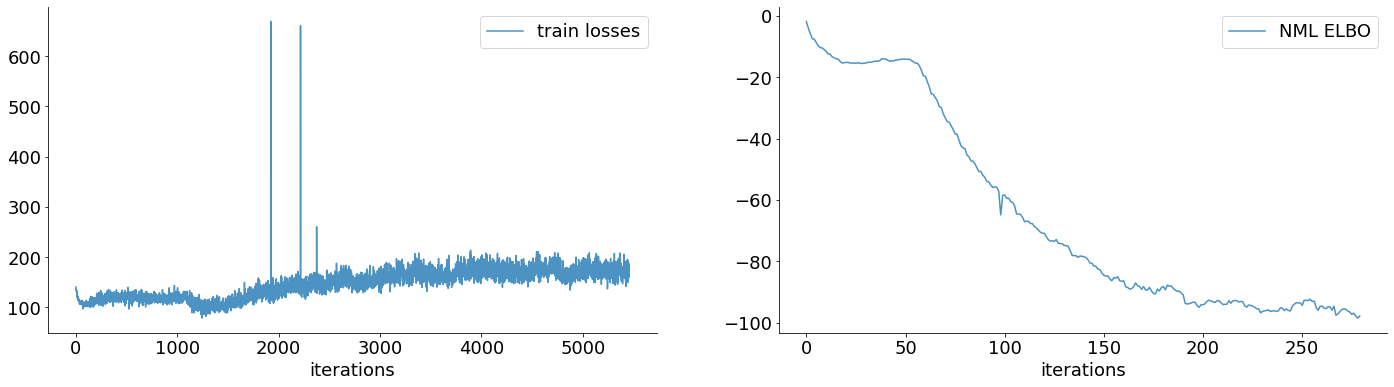

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
ax[0].plot(train_losses, label="train losses", alpha=0.8)
ax[0].set_xlabel("iterations")
ax[0].legend()
sns.despine()
ax[1].plot(train_elbos, label="NML ELBO", alpha=0.8)
ax[1].set_xlabel("iterations")
ax[1].legend()
sns.despine()